# Classification - Assignment 2

## Data and Package Import

In [448]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])


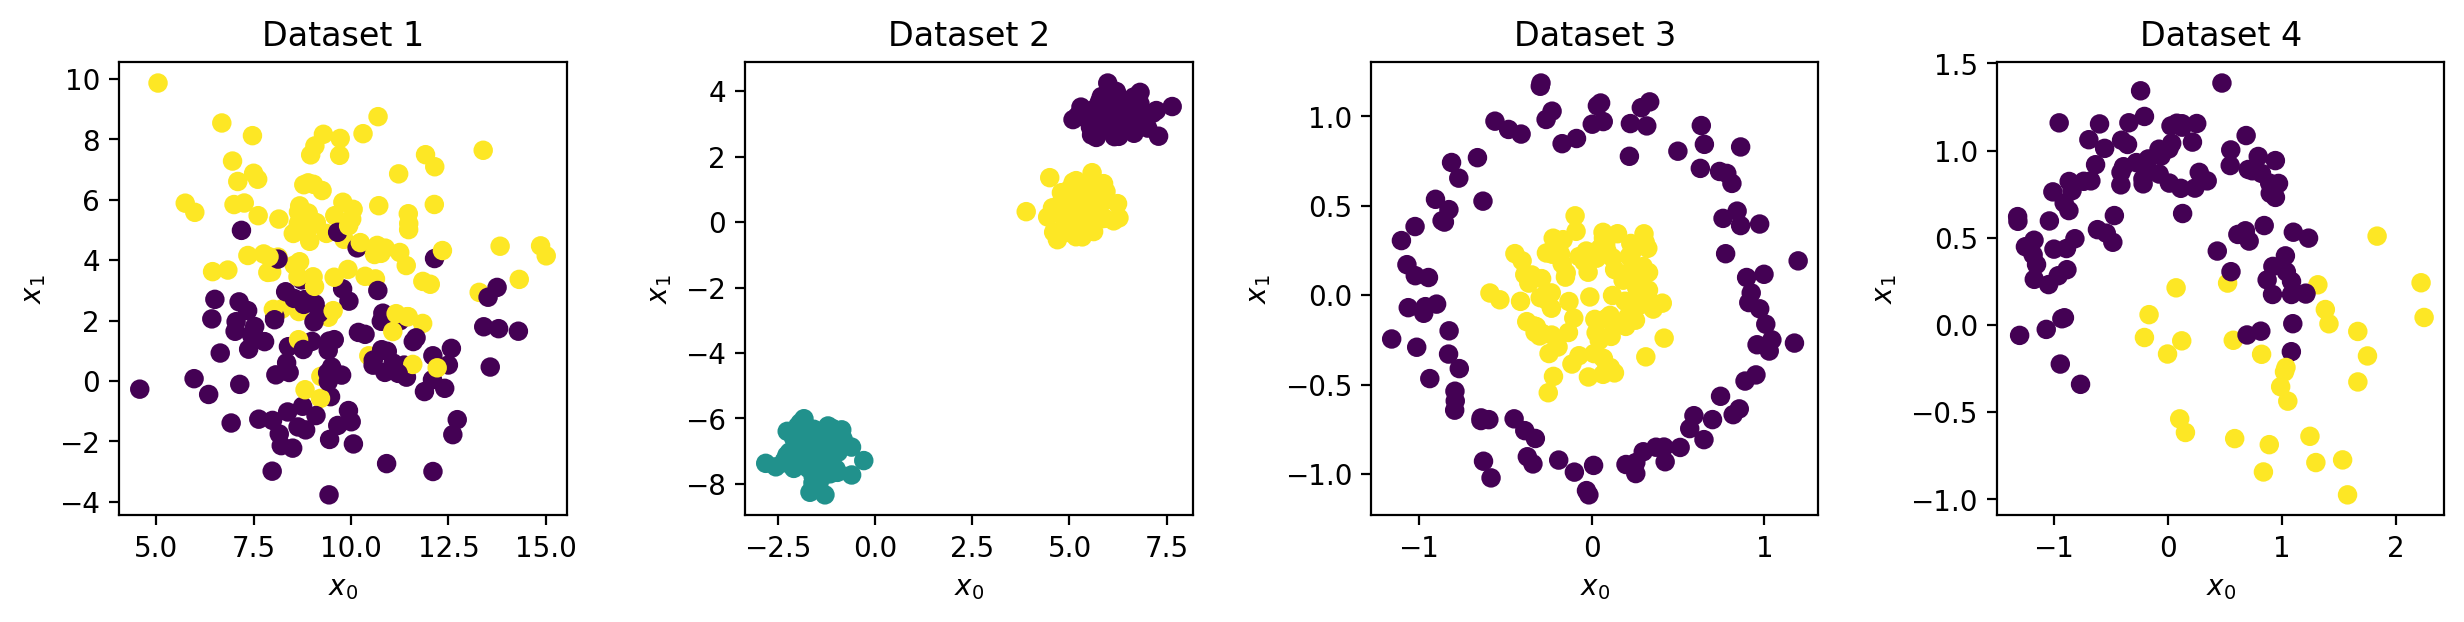

In [449]:
from sklearn.datasets import make_blobs, make_moons, make_circles
np.random.seed(4)

noisiness = 1

X_blob, y_blob = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

X_mc, y_mc = make_blobs(n_samples = 200, centers = 3, cluster_std = 0.5 * noisiness, n_features = 2)

X_circles, y_circles = make_circles(n_samples = 200, factor = 0.3, noise = 0.1 * noisiness)

X_moons, y_moons = make_moons(n_samples = 200, noise = 0.25 * noisiness)

N_include = 30
idxs = []
Ni = 0
for i, yi in enumerate(y_moons):
    if yi == 1 and Ni < N_include:
        idxs.append(i)
        Ni += 1
    elif yi == 0:
        idxs.append(i)

y_moons = y_moons[idxs]
X_moons = X_moons[idxs]

fig, axes = plt.subplots(1, 4, figsize = (15, 3), dpi = 200)

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]

labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:, 0], Xi[:, 1], c = yi)
    axes[i].set_title(labels[i])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')

fig.subplots_adjust(wspace = 0.4);

In [450]:
df = pd.read_csv('data/perovskite_data.csv')
X_perov = df[['nA', 'nB', 'nX', 'rA (Ang)', 'rB (Ang)', 'rX (Ang)', 't', 'tau']].values
y_perov = df['exp_label'].values

## 1. k-nearest Neighbors Model

### 1-NN
**Calculate the accuracy of a 1-nearest Neighbors model for the training data.**

A 1-nearest Neighbors model considers a point as its own nearest neighbors.

*Hint: the block below is not a code block.*

1 nearest neighbor is the point itself. The 1-nearest neighbors model would be memorizing all the data point so the accuracy 1. 

**Will this be a reliable indicator of its accuracy for testing data?**

Briefly explain your answer.

No. We know everything about the training set but we dont know if the model can be generalized to a new dataset 

### Weighted Neighbors Classification

Instead of selecting the k-nearest neighbors to vote, we could design an algorithm where all neigbors get to vote, but their vote is weighted inversely to their distance from the point of interest:

$y_i = \sum_j y_j/(||x_i - x_j||)$

where $j$ is an index over all training points.

The class will be assigned as follows:

- class 1 if $y_i \geq 0$

- class -1 if $y_i < 0$

In [451]:
def distance(x1, x2):
    return np.linalg.norm(x1 - x2, 2)

In [452]:
def get_neighbor(x, x_list):
    dist_pairs = []
    for i, xi in enumerate(x_list):
        dist = distance(x, xi)
        dist_pairs.append([dist, i])
    return dist_pairs

**Write a function that assigns a class to a point.**

The function should take the followings as arguments:
- a single point `x`
- a list of training points `x_list`
- a list of training labels `y_list`

You may want to use functions above. You will also need to add a statement to avoid dividing by zero if the point is in the training set. If the distance between 2 points is zero, then the label from the same point in the training set should be used (e.g. if $x_i = x_j$ then $y_i = y_j$).

In [453]:
from scipy.stats import mode
def assign_class(x, x_list, y_list):
    votes = 0
    for i in range (x_list.shape[0]):
        dist = distance(x, x_list[i])
        votes += y_list[i] / dist
    if votes >= 0:
        return 1 
    else:
        return -1
    assignment = votes
    assignment = mode(votes)[0][0] 
    return assignment

**Write a function that returns the prediction for a given list of testing points.**

The function should take the followings as arguments:
- a list of testing points `X`
- a list of training points `X_train`
- a list of training labels `y_train`

In [454]:
def weighted_neighbors(X, X_train, y_train):
    y_out = []
    for xi in X:
        y_out.append(assign_class(xi, X_train, y_train))
    y_out = np.array(y_out)
    return y_out

**Train the model for the perovskite dataset using a random selection of 75% of the data as training data.**

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size = 0.25)
knn=KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)
y_hat = knn.predict(X_test)

**Compute the accuracy and precision of the prediction.**

In [456]:
from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy',accuracy_score(y_test,y_hat))
print('precision',precision_score(y_test,y_hat))

accuracy 0.9027777777777778
precision 0.9545454545454546


**Train a 5-NN model using the same training data.**

In [457]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_5NN = knn.predict(X_test)

**Compute the accuracy and precision.**

In [458]:
from sklearn.metrics import precision_score, confusion_matrix
print('precision',precision_score(y_test,y_5NN))

precision 0.9550561797752809


In [459]:
from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy',accuracy_score(y_test,y_5NN))

accuracy 0.9097222222222222


In [460]:
from sklearn.metrics import accuracy_score, confusion_matrix
tn,fp,fn,tp=confusion_matrix(y_test,y_5NN).ravel()

## 2. Multi-dimensional Classification

### Simple logistic regression
**Train a logistic regression model using all columns except the `tau` column of the perovskite dataset.**

You may use some functions that have been already built in the previous assignments.

In [461]:
from sklearn.linear_model import LogisticRegression
X_train=X_perov[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size = 0.25)
logisticR=LogisticRegression()
logisticR.fit(X_train,y_train)
y_logisticR=logisticR.predict(X_test)

**Plot the confusion matrix.**

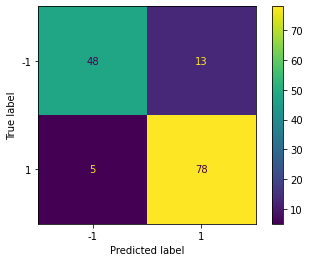

In [462]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logisticR,X_test,y_test)

**Compute the accuracy, precision and recall.**

In [463]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
print('accuracy',accuracy_score(y_test,y_logisticR))
print('precison',precision_score(y_test,y_logisticR))
print('recall',recall_score(y_test,y_logisticR))

accuracy 0.875
precison 0.8571428571428571
recall 0.9397590361445783


### 6745 Only: Customizing non-linear boundaries

In this problem, you will create a single custom feature that improves the separation performance as much as possible.

**Plot the `y_perov` as a function of `rA (Ang)` and `rB (Ang)`.**

Text(0, 0.5, 'rB (Ang)')

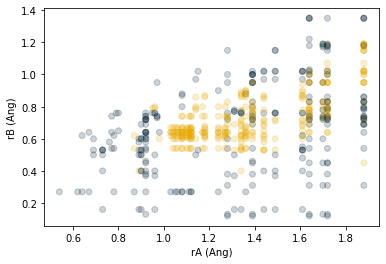

In [464]:
X_rA=X_perov[:,3]
X_rB=X_perov[:,4]

fig, axes = plt.subplots()
axes.scatter(X_rA, X_rB, c = clrs[y_perov], alpha = 0.2)
axes.set_xlabel(feature_columns[3])
axes.set_ylabel(feature_columns[4])

**Build a baseline model based on logistic regression.**

Report the accuracy and precision of the baseline model.

In [465]:
from sklearn.linear_model import LogisticRegression
X_rA_rB=X_perov[:,3:5]
logisticR=LogisticRegression()
logisticR.fit(X_rA_rB,y_perov)
y_logisticR=logisticR.predict(X_rA_rB)
print('accuracy',accuracy_score(y_perov,y_logisticR))
print('precision',precision_score(y_perov,y_logisticR))

accuracy 0.6649305555555556
precision 0.625


**Plot the prediction of the baseline model.**

Text(0, 0.5, 'rB (Ang)')

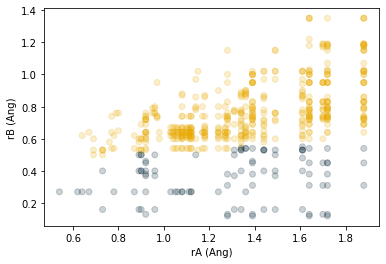

In [466]:
fig, axes = plt.subplots()
axes.scatter(X_rA, X_rB,c = clrs[y_logisticR], alpha = 0.2)
axes.set_xlabel(feature_columns[3])
axes.set_ylabel(feature_columns[4]) 
### re-run all the cells and made the new graph.... have to run all the code from beginning to end

**Create a new feature based on a non-linear combination of `rA (Ang)` and `rB (Ang)`.**

Plot the new feature as a function of `rA (Ang)`.

In [467]:
import math
X_rX=X_perov[:,5]
a=math.sqrt(2)
X_goldschmidt=(X_rA+X_rX)/(a*(X_rB+X_rX))
X_goldschmidt.shape
X_rA.shape

(576,)

**Build a new model that includes `rA (Ang)`, `rB (Ang)` and your new feature.**

Report the accuracy and precision.

In [468]:
import numpy as np
X_1=X_goldschmidt.reshape(-1,1)
X_2=X_rA.reshape(-1,1)
X_3=X_rB.reshape(-1,1)
X_threeF=np.column_stack((X_1,X_2,X_3))# use one parathesis to put all three columns together. 
X_threeF.shape

(576, 3)

In [469]:
logisticR=LogisticRegression()
logisticR.fit(X_threeF,y_perov)
y_threeF=logisticR.predict(X_threeF)
print("accuracy",accuracy_score(y_perov,y_threeF))
print("precision",precision_score(y_perov,y_threeF))

accuracy 0.671875
precision 0.6286307053941909


**Plot the result of your new model.**

Text(0, 0.5, 'y_threeF')

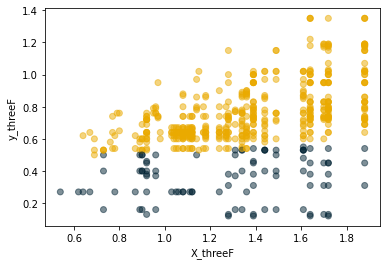

In [470]:
import pylab as plt
fig, axes = plt.subplots()
axes.scatter(X_rA, X_rB,c = clrs[y_threeF], alpha = 0.5)
axes.set_xlabel('X_threeF')
axes.set_ylabel('y_threeF')

**Briefly explain how you decided on the feature.**

I used the Goldschmidt's tolerance factor to make the new feature which is an indicator for the stability and distortion of crystal structures.It is used to describe the perovskite ABO3 structure. The inclusion of Goldschimidt tolerance factor did not significantly improve the accuracy of the model. 

## 3. Comparison of Classification Model

In this problem, you will compare the classification performance of three different models using the perovskite dataset.

**Choose three different classification models and import them.**

These could be models discussed in the lectures, or others that you have learned about elsewhere.

In [471]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_perov,y_perov)
y_dtree = dtree.predict(X_perov)
cm_train = confusion_matrix(y_perov, y_dtree)
y_dtree = dtree.predict(X_test)
cm_test = confusion_matrix(y_test, y_dtree)

In [472]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_perov, y_perov)
y_kNN = knn.predict(X_perov)

In [473]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_perov, y_perov)
y_NB = NB.predict(X_perov)

In [474]:
from sklearn.svm import SVC
svc=SVC(kernel='rbf')

**Make a hyperparameter grid for each model.**

You should optimize at least one hyperparameter for each model.

In [475]:
# for dtree 
from sklearn.model_selection import GridSearchCV
max_depth=np.array([4,6,8,10,20])

In [476]:
#for svc
sigmas=np.array([1e-3,1e-2,1e-1,1,10,100])
gammas=1./2/sigmas**2
alphas=np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
Cs=1/alphas

In [481]:
#for kNN
n_neighbors=np.array([2,8,10,20,30])

In [489]:
# for Gaussian NB
vari_s=np.array([1e-10,1e-5,1e-4,1e-3,1e-2])


**Optimize hyperparameters.**

First, you select a validation set using hold-out (`train_test_split`). Optimize hyperparameters using `GridSearchCV` on the training set.

In [478]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size=0.33)

In [490]:
#for dtree
dtree_hyperp={'max_depth':max_depth}
dtree_search=GridSearchCV(dtree,dtree_hyperp)
dtree_search.fit(X_train,y_train)
dtree_best=dtree_search.best_estimator_
dtree_score=dtree_search.best_score_

print('Decision tree estimator',dtree_best)
print('score',dtree_score)


Decision tree estimator DecisionTreeClassifier(max_depth=4)
score 0.8961038961038961


In [491]:
#for kNN
n_neighbors=np.array([2,8,10,14,15,18,20])
kNN=KNeighborsClassifier()
kNN_hyp={'n_neighbors':n_neighbors}
kNN_search=GridSearchCV(kNN,kNN_hyp)
kNN_search.fit(X_train,y_train)
kNN_best=kNN_search.best_estimator_
kNN_score=kNN_search.best_score_

print('kNN estimator',kNN_best)
print('score',kNN_score)

kNN estimator KNeighborsClassifier(n_neighbors=10)
score 0.9064935064935064


In [554]:
#for GaussianNB
var_smoothing=np.array([1e-10,1e-5,1e-4,1e-3,1e-2])
NB = GaussianNB()
NB_hyp={'var_smoothing':var_smoothing}
NB_search = GridSearchCV(NB,NB_hyp)
NB_search.fit(X_train, y_train)
NB_best=NB_search.best_estimator_
NB_score=NB_search.best_score_
print('NB estimator',NB_best)
print('score',NB_score)

NB estimator GaussianNB(var_smoothing=1e-10)
score 0.7740259740259741


In [555]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train) #Shuffle everything just for good measure

sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas

parameter_ranges = {'C': Cs, 'gamma': gammas}

svc = SVC(kernel = 'rbf')

svc_search = GridSearchCV(svc, parameter_ranges)
svc_search.fit(X_train, y_train)
svc_search.best_estimator_, svc_search.best_score_

(SVC(C=10.0, gamma=0.5), 0.922077922077922)

**Compare the accuracy by predicting the results of the validation set.**

In [558]:
dtree_best=DecisionTreeClassifier(max_depth=4)
dtree_best.fit(X_train,y_train)
y_dtree_best=dtree_best.predict(X_test)

kNN_best=KNeighborsClassifier(10)
kNN_best.fit(X_train,y_train)
y_kNN_best=kNN_best.predict(X_test)

svc_best=SVC(kernel='rbf',gamma=0.5,C=10)
svc_best.fit(X_train,y_train)
y_svc_best=svc_best.predict(X_test)

NB_best=GaussianNB(var_smoothing=1e-10)
NB_best.fit(X_train,y_train)
y_NB_best=kNN_best.predict(X_test)


print('accuracy_dtree',accuracy_score(y_test,y_dtree_best))
print('accuracy_kNN',accuracy_score(y_test,y_kNN_best))
print('accuracy_svc',accuracy_score(y_test,y_svc_best))
print('accuracy_NB',accuracy_score(y_test,y_NB_best))

accuracy_dtree 0.93717277486911
accuracy_kNN 0.9424083769633508
accuracy_svc 0.9476439790575916
accuracy_NB 0.9424083769633508


**Briefly describe your conclusions based on the results.**

Performance of svc is the best, which is slightly better than kNN and NB model.